In [280]:
import os
import time
import subprocess
import math
import fileinput
import sys
from astropy.io import fits 
import numpy as np
import matplotlib.pyplot as plt
import re
from dateutil.parser import parse
import datetime
from scipy.optimize import curve_fit
from scipy import ndimage

import ana_connie_lib as ana

# '''

# import scipy.ndimage as ndimage
# import glob
# import copy
# import pandas as pd
# import os

# from scipy import optimize
# from dateutil.parser import parse
# from scipy.stats import poisson, norm

# from scipy.signal import find_peaks
# from matplotlib import colors
# import re
# import argparse
# import sys
# import warnings
# import skimage.measure as sk
# from scipy.optimize import OptimizeWarning
# warnings.simplefilter("error", OptimizeWarning) # If the fit are not good get an error
# warnings.simplefilter("error", RuntimeWarning) # for overflow in exponentials and ivalid values get an error
# '''

In [281]:
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    }) 

In [282]:
# ----------------------------------------------------------
# De ReconLib.py del Serial Register Event detection analysis
# Jaime Guerra 
# Mauricio Martinez
#-----------------------------------------------------------

import pickle as pkl 

# Verifica tamaño de la imagen, Revisar como funciona
def VerifySizeXY(X,Y):
    if type(X) is list:
        LenX = []
        LenY = []
        for Xs,Ys in zip(X,Y):
            LenX.append(len(Xs))
            LenY.append(len(Ys))
    else:
        LenX = len(X)
        LenY = len(Y)
    
    if type(X) is list:
        Xaux = []
        Yaux = []
        count = 0 
        for Xs,Ys in zip(X,Y):
            diff = LenX[count] - LenY[count]
            if diff > 0:
                Xaux.append(Xs[:(-diff)])
                Yaux.append(Ys)
            elif diff < 0:
                Yaux.append(Ys[:diff])
                Xaux.append(Xs)
        X = Xaux
        Y = Yaux
    else:
        if LenX != LenY:
            diff = LenX - LenY
            if diff > 0:
                X = X[:(-diff)]
            elif diff < 0:
                Y = Y[:diff]
    return X,Y

# Guarda imagen en archivo PDF, usa VerifySize
def SavePlot2File(X,Y,LabelL,Marker='line',Log=None):
    Title = LabelL[0]
    Xlabel = LabelL[1]
    Ylabel = LabelL[2]
    filename = LabelL[3]
    Legend = LabelL[4]
    FontDict={'color':  'black','weight': 'normal','size': 18}
    X,Y = VerifySizeXY(X,Y)
    if Marker == 'symbol': 
        plt.scatter(X,Y,marker='+',c='b',label=Legend)
    elif Marker == 'line':
        if type(X) is list:
            for Xs,Ys,Legends in zip(X,Y,Legend):
                plt.plot(Xs,Ys,label=Legends)
        else:
            plt.plot(X,Y,label=Legend)
        
    if Log == 'log':
        plt.yscale('log')

    plt.xlabel(Xlabel,fontdict=FontDict)
    plt.ylabel(Ylabel,fontdict=FontDict)
    plt.title(Title,fontdict=FontDict)
    plt.savefig(filename,format='pdf',dpi=300,orientation='landscape')
    plt.clf()

# saveObject2File
# -Guarda objetos de cualquier tipo para exportarlos despues a otros codigos
# -Util cuando un proceso devuelve un objeto pero tarda mucho en hacerlo.
# -Se sugiere utilizar saveObjetc2File para compartir diccionarios con informacion,
# Imagenes de algun analisis y abrir posteriormente en la ventana interactiva de matplotlib
# -Los objetos en formato pkl se recuperan con la funcion readObjectFromFile.

def saveObject2File(filename,object):
    with open(filename, 'wb') as file:
        pkl.dump(object,file)
    return 0

# readObjectFromFile 
# recupera un objeto almacenado en un archivo pkl para ser utilizado 
# en el codigo. Objetos que resultan de procesos muy complejos y que tardan mucho en ser calculados 
# pueden guardarse en archivos pkl utilizando saveObject2File y utilizarse despues.

def readObjectFromFile(filename):
    with open(filename, 'rb') as file:
        object = pkl.load(file)
    return object

# plot de una imagen con formato para ser presentado de una manera sencilla y con algunas herramientas como 
# barra de color 
def PlotImage(Image,MinRange=None,MaxRange=None):
    try:
        if MinRange > MaxRange:
            Aux = MaxRange
            MaxRange = MinRange
            MinRange = Aux
    except TypeError:
        MinRange=None
        MaxRange=None
    plt.imshow(Image, cmap='viridis',vmin=MinRange,vmax=MaxRange,origin="lower")
    plt.colorbar()
    plt.show()


# Plot2Images
# esta es la Version 2 que se utiliza en ReconLib, utiliza el metodo subplots y usualmente la utilizamos para comparar
# una imagen con la mascara generada en algun porceso. 
# El orden de ingresar los datos es la imagen como primer argumento y la mascara como segunda imagen.
# puede hacer plot de 2 imagenes y compararlas
# puede almacenar la figura como un objeto utilizando saveObject2File para mostrarse despues.

def Plot2Images(Image,Mask,MinRange=None,MaxRange=None, colorBar_1=True, colorBar_2=True, saveFig=False):
    try:
        if MinRange > MaxRange:
            Aux = MaxRange
            MaxRange = MinRange
            MinRange = Aux
    except TypeError:
        MinRange=None
        MaxRange=None
    
    fig, (Datos, Mascara) = plt.subplots(ncols=2,sharex=True, sharey=True, figsize=(12, 4))# plt.subplots(2,1)

   
    if Mask.max()==1:
        left=Datos.imshow(Image, cmap='viridis',vmin=Mask.min(),vmax=Mask.max(), origin="lower")
    else:
        left=Datos.imshow(Image, cmap='viridis',vmin=MinRange,vmax=MaxRange, origin="lower")
    if colorBar_1:
        fig.colorbar(left,ax=Datos)
    
   
    right=Mascara.imshow(Mask, cmap='viridis', vmin=MinRange,vmax=MaxRange,origin="lower")
    if colorBar_2:
        fig.colorbar(right, ax=Mascara)

    if saveFig:
        saveObject2File("ImageTest.pkl",fig)#saveFig
    else:
        plt.show()


def plotHistogram(data):
    histo, bins_edges = np.histogram(data,bins='fd')
    class_marks = (bins_edges[:-1]+bins_edges[1:])/2
    plt.hist(class_marks,bins=bins_edges,weights=histo)
    plt.show()

# Convert the MCM.fz to MCM with 16 channels
Code based on one_mcm_256chToolV4_reverse_os.py

In [283]:
#Functions definition==============================================================================================
def GetSingleCCDImage(hdul,LTA_channel,ColInit,NCOL,step,NrOfMCMs):
	#hdul: list of hdu of the muxed fit file
	#LTA_channel
	#ColInit: First column in the muxed image
	#NCOL: Number of columns in the image
	MuxedImage=hdul[LTA_channel].data
	step2=step*NrOfMCMs
	LastCol=ColInit+(int(NCOL)-1)*step2
	indexCol=list(range((ColInit-1),LastCol,step2))
	DeMuxedImage=MuxedImage[:, indexCol]
	return DeMuxedImage #return demuxed image

In [284]:
filePath='/home/oem/datosFits/mcm_data/ansamp/'
#fileName='mcm029_test__ANSAMP25_full_34.fz'
fileName='barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP100_24.fz'
#fileName='barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP100_24.fz'
h=fits.open(filePath+fileName)
h.info()
#Get some header values
ANSAMP=int(h[1].header['ANSAMP'])
NCOL=int(h[1].header['NCOL'])
print(ANSAMP,NCOL)
dictPo={}

Filename: /home/oem/datosFits/mcm_data/ansamp/barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP100_24.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU    165   (19200, 100)   int32   
  2  COMPRESSED_IMAGE    1 CompImageHDU    164   (19200, 100)   int32   
  3  COMPRESSED_IMAGE    1 CompImageHDU    164   (19200, 100)   int32   
  4  COMPRESSED_IMAGE    1 CompImageHDU    164   (19200, 100)   int32   
100 1200


In [285]:
#Channel mapping between MCM and Mux in the front-end==============================================================
#MCM=>FLEX=>idb=>Front end electronics
# 1  5  9 13
# 2  6 10 14 => to MCM flex
# 3  7 11 15 => to MCM flex
# 4  8 12 16
MappingToMux=[8,7,6,16,15,14,13,12,11,10,9,5,4,3,2,1] #SENSEICOPY Mapping from MCM positions to MUX inputs.CCD1=>Mux S8, CCD2=>Mux S7, CCD3=>Mux S6,...CCD16=>Mux S1 
#MappingToMux=[1,3,2,4,5,9,10,11,12,13,14,15,16,7,6,8];  #Old mapping with idb and 50 pins front end:
MappingToOHDUinfits=[1,5,9,13,2,6,10,14,3,7,11,15,4,8,12,16] #Mapping from Mux inputs to OHDU positions in fits file
#==================================================================================================================

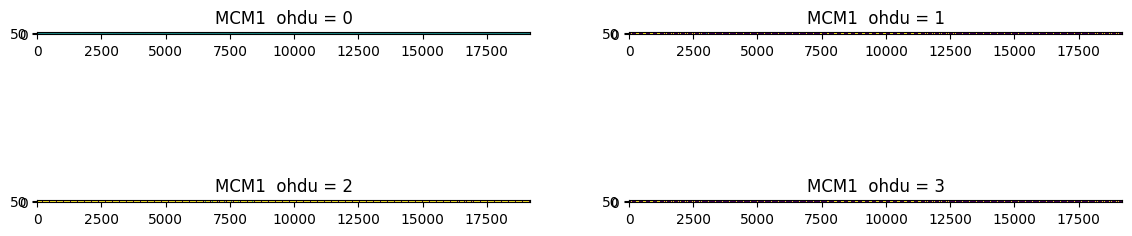

In [286]:
plt.figure(figsize=(14,4))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(h[i+1].data[:,:]-np.median(h[i+1].data), vmin=-10, vmax=10)
    plt.title('MCM1  ohdu = {:d}'.format(i))
#plt.savefig('BeforeXTALK.png', bbox_inches='tight', dpi=100)

In [287]:
hduUse=2  # arbitrary indicated by Claudio.  4 also has signal but we will not use it for analysis
print("the hdu with signal is: ",hduUse)


the hdu with signal is:  2


In [288]:
#output file name
MCMNro=1
outname='MCM'+str(MCMNro)+'_Demuxed_'+re.sub(".fz","",fileName)+'.fits';
print(outname)
pdfname='MCM'+str(MCMNro)+'_Demuxed_'+re.sub(".fz","",fileName)

MCM1_Demuxed_barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP100_24.fits


# Crear archivo Fits a partir de un arreglo 

In [289]:
step=16
#Get 16-demuxed Images from the MCM
#Primary HDU no data, only main header
Primaryhdu_MCM = fits.PrimaryHDU() # Create primary HDU without data
hdu_list_MCM = fits.HDUList([Primaryhdu_MCM]) #Create HDU list
hdu_list_MCM[0].header=h[0].header
for i in range(0,16):
	MapMCM_ColInit=MappingToMux[MappingToOHDUinfits[i]-1]  #REVISAR ACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaaa!
	datai=np.int32(GetSingleCCDImage(h,hduUse,MapMCM_ColInit,NCOL,step,1))   # Datos que desean ser almacenados
	#print(datai.dtype)
	image_hdu=fits.ImageHDU(datai);
	image_hdu.header=h[hduUse].header #Repear the header of the used hdu channel into all the 16-channles
	image_hdu.header.set('NSAMP',ANSAMP)
	hdu_list_MCM.append(image_hdu)

In [290]:
h[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 

In [291]:
h[hduUse].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1200 / length of data axis 1                          
NAXIS2  =                  100 / length of data axis 2                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
ANSAMP  = '100     '           / Smart sequencer variable                       
CCDNCOL = '2216    '           / Smart sequencer variable                       
CCDNPRES= '7       '           / Smart sequencer variable                       
CCDNROW = '2556    '           / Smart sequencer variable                       
NCOL    = '1200    '           / Smart sequencer variable                       
NCOL1   = '1107    '        

In [292]:
#imprime el Header para verlo en un archivo de texto  # 15 Feb
fileHeader=open('fileHeader.txt', 'w')
fileHeader.write(repr(h[1].header))
fileHeader.close()


In [293]:
#save demux file
hdu_list_MCM.writeto(outname,overwrite=True);
hdu_list_MCM.close()

In [294]:
hm = hdu_list_MCM
hmb = hdu_list_MCM

print(hm.info())
#print(hm[1].header)

# Some infos hmb = hdu_list_MCMfrom the header:
CCDNROW = hm[1].header["CCDNROW"]
CCDNCOL = hm[1].header["CCDNCOL"]
NROW = hm[1].header["NROW"]
NCOL = hm[1].header["NCOL"]
NSAMP = hm[1].header["NSAMP"]
# MCMs/
ANSAMP = hm[1].header["ANSAMP"]

print("CCDNROW = ", CCDNROW, " - CCDNCOL = ", CCDNCOL, " - NROW = ", NROW, " - NCOL = ", NCOL, " - ANSAMP = ", NSAMP)


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 ImageHDU       164   (1200, 100)   int32   
  2                1 ImageHDU       164   (1200, 100)   int32   
  3                1 ImageHDU       164   (1200, 100)   int32   
  4                1 ImageHDU       164   (1200, 100)   int32   
  5                1 ImageHDU       164   (1200, 100)   int32   
  6                1 ImageHDU       164   (1200, 100)   int32   
  7                1 ImageHDU       164   (1200, 100)   int32   
  8                1 ImageHDU       164   (1200, 100)   int32   
  9                1 ImageHDU       164   (1200, 100)   int32   
 10                1 ImageHDU       164   (1200, 100)   int32   
 11                1 ImageHDU       164   (1200, 100)   int32   
 12                1 ImageHDU       164   (1200, 100)   int32   
 13                1 ImageHDU       164   (1200, 100)   in

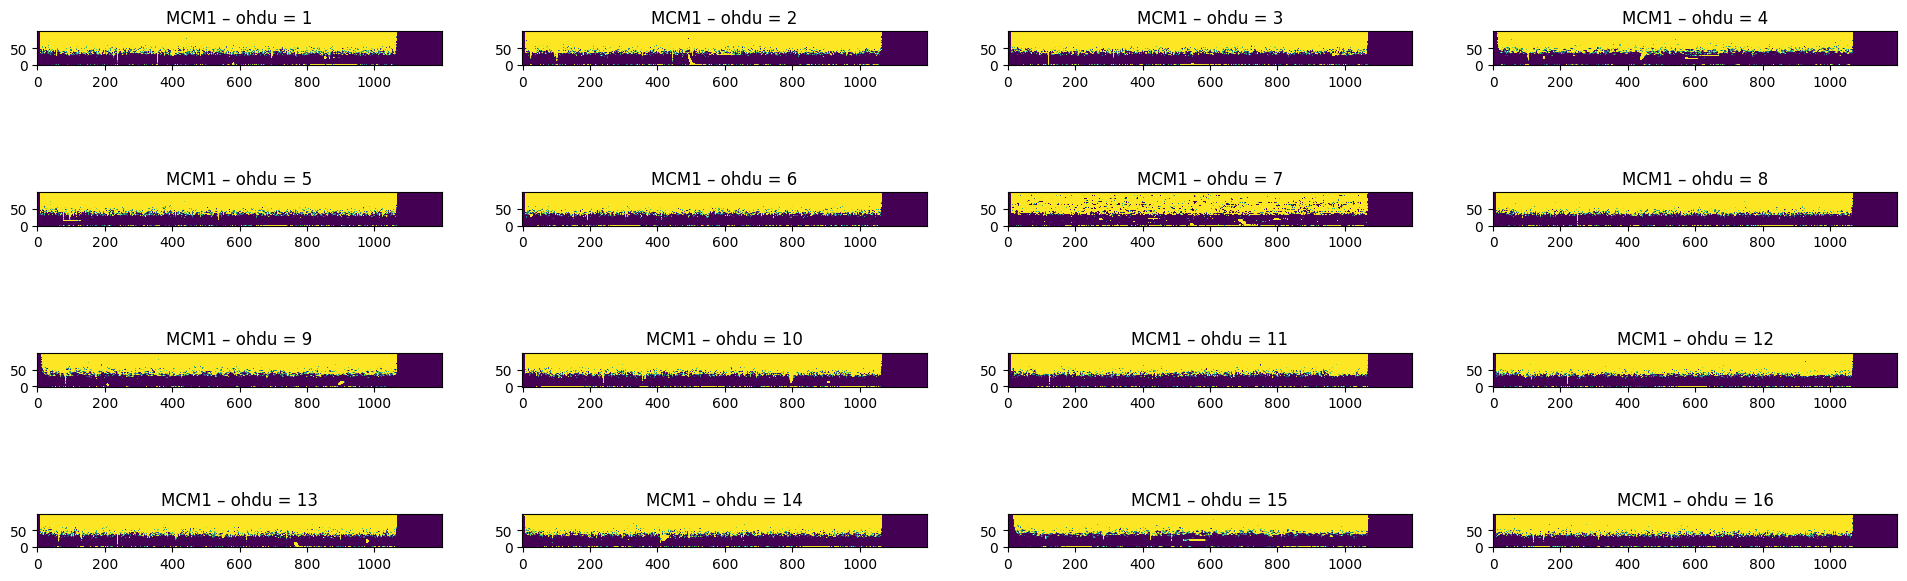

In [295]:
nCCDs=16

# define active and overscan masks
active_mask = np.s_[:, 10:1057] # 
overscan_mask = np.s_[:, -91:-1] 

plt.figure(figsize=(24,8))
for i in range(nCCDs):
    plt.subplot(4,4,i+1)
    plt.imshow(hm[i+1].data[:,:]-np.median(hm[i+1].data), vmin=-50, vmax=50)
    plt.title('MCM1 – ohdu = {:d}'.format(i+1))

In [296]:
# header info
#print(hm[1].header["DATEEND"],hm[1].header["DATESTART"])
start = parse(hm[1].header["DATESTART"]+"Z").timestamp()
end = parse(hm[1].header["DATEEND"]+"Z").timestamp()
deltatime = datetime.timedelta(seconds=end-start)
readout_time = deltatime.total_seconds()
print("Readout time = ", readout_time, "s")
print("               ", round(readout_time/3600,2), "h")
print("               ", round(readout_time/86400,3), "days")

Readout time =  444.0 s
                0.12 h
                0.005 days


In [297]:
# ------------------------------------------------------------------------------
#
# ---- To compute the baseline evolution in function of the row number
def Baseline(h, overscan_mask, iMCM, nCCDs, doPlot, pdfname):
    mediana = []
    plt.figure(figsize=(15,6))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    for i in range(0,nCCDs):
        m = np.median(h[i+1].data[overscan_mask], axis=1,keepdims=True)
        mediana.append(m)
        x = np.arange(len(m))
        plt.plot(x,m-m[0],label='ohdu = {:d} - ref = {}'.format(i+1,m[0]))
        plt.xlim(0,len(m)*1.30)
        plt.xlabel('iROW', fontsize=14)
        plt.ylabel('Baseline (ADUs)', fontsize=14)
        plt.title('MCM {:d}'.format(iMCM),fontsize=16)
        plt.legend(fontsize=12)
    # to save the plot
    if doPlot:
        pdf_filename = f'baseline_{pdfname}.pdf'
        plt.savefig(pdf_filename, format='pdf')
    plt.close()
    return mediana
# ------------------------------------------------------------------------------
#

In [298]:
doPlot=1
# made the baseline plot and print the baseline diffetences
baseline = Baseline(hm, overscan_mask, MCMNro, nCCDs, doPlot, pdfname)  #Evolucion del Base Line
#

In [299]:
hmb = np.copy(hm)                   #se sobre escribe el dato, 
for i in range(nCCDs):      #el valor de la imagen sera el de la imagen cruda menos la mediana
    hmb[i+1].data = (hm[i+1].data.astype('float64') - np.median(hm[i+1].data[overscan_mask], axis=1, keepdims=True))/int(ANSAMP)
    


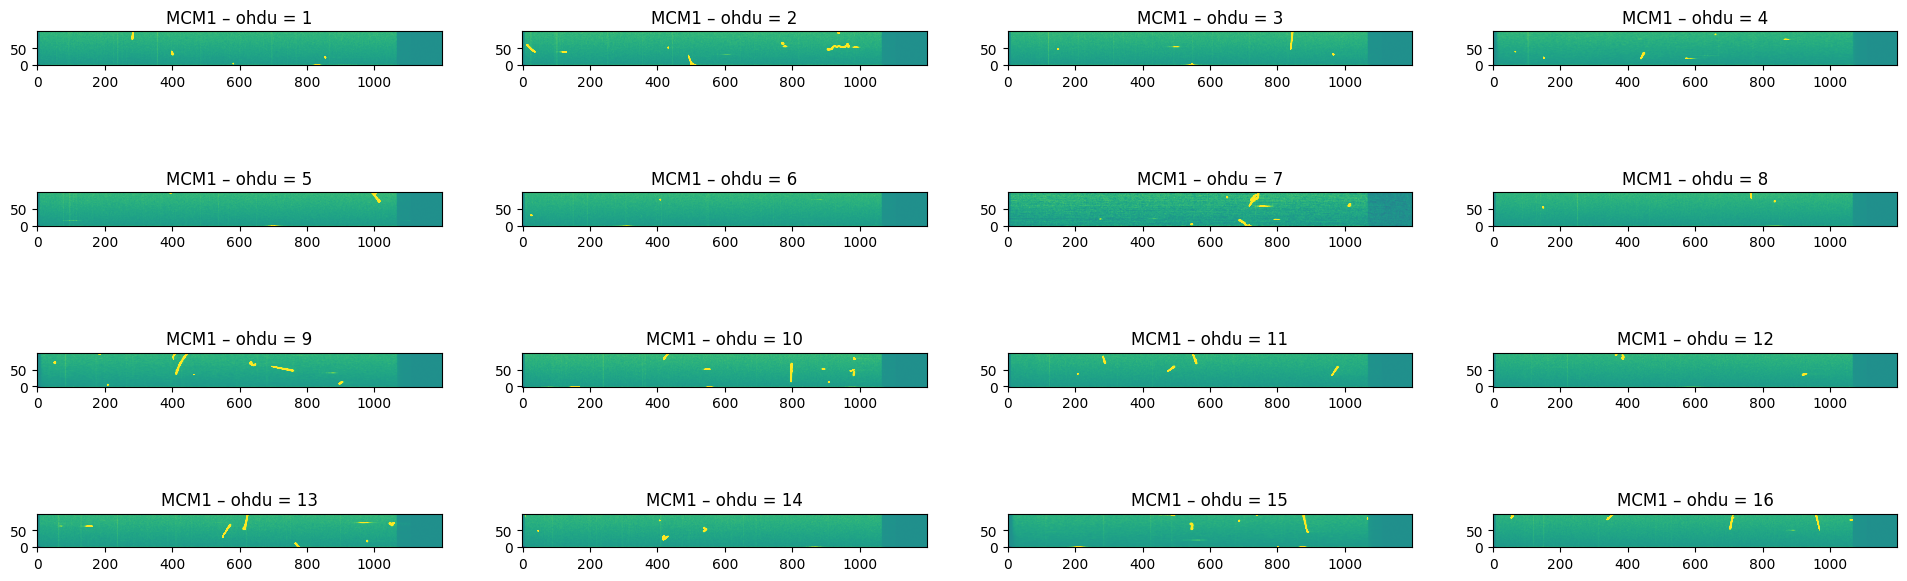

In [300]:
plt.figure(figsize=(24,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(hmb[i+1].data, vmin=-50, vmax=50)    #Plot de cada imagen en un rango de -500 a 500 ADUS
    plt.title('MCM1 – ohdu = {:d}'.format(i+1))

In [301]:
ohdusOK = np.zeros((16,), dtype=int)
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)             #para que es este Histograma, que se ve aqui????
    y, x, _ = plt.hist(hmb[i+1].data[active_mask].flatten(),100,density=True, histtype='step', cumulative=True)
    print(i,x.max())
    if x.max()>100: ohdusOK[i]=1
plt.close()
print(ohdusOK)

#y, x, _ = plt.hist(hmb[1].data[active_mask].flatten(),100,density=True, histtype='step', cumulative=True)

0 651.095
1 1008.04
2 2714.11
3 2486.84
4 2420.855
5 2101.565
6 766.23
7 1651.985
8 2706.575
9 4850.86
10 2235.65
11 201.38
12 2420.36
13 985.93
14 4061.055
15 1104.345
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [302]:
# ------------------------------------------------------------------------------
#
# ----  Single Gaussian for the noise computation 
def gaussian1(x,m1,s1,a1):
    return a1*np.exp(-1/2*((x-m1)/s1)**2)
#
# ---- Two Gaussians shifter by g = gain 
def gaussian2(x,m1,s,a1,g,a2):   #data, mean, stdDev, h1, gain, h2
    return a1*np.exp(-1/2*((x-m1)/s)**2)+a2*np.exp(-1/2*((x-m1-g)/s)**2)
#
# ---- 
def convolution(x, mu, sigma, A, lamb, Nmax=10):
    y = 0.
    for i in range(0, Nmax+1):
        y += (lamb**i)/float(math.factorial(i)) * \
            np.exp(-0.5*((x-i-mu)/float(sigma))**2)
    return A*np.exp(-lamb)*y/(np.sqrt(2*np.pi*sigma**2))
#
# ------------------------------------------------------------------------------
# 


In [303]:
# ------------------------------------------------------------------------------
# 
def Noise(h, overscan_mask, iMCM, nCCDs, dataOK, doPlot=False, pdfname='noise'):
    noise = []
    ANSAMP=h[1].header["ANSAMP"]
    fig, axs = plt.subplots(ncols=4,nrows=4,figsize=(12,8))

    i=0
    for ncol in axs:
       for nrow in ncol:
            
            hist,bins,_=nrow.hist(h[i+1].data[overscan_mask].flatten(), bins=100, range=(-100,100))
            x=(bins[1:]+bins[:-1])/2
            #nrow.plot(x,nrow[0],label='MCM {:d} – ohdu = {:d}'.format(iMCM,i+1))
            # gaussian fit
            try:
                popt,pcov=curve_fit(gaussian1,x,hist,p0=[0,50,1000])
                popt=abs(popt)
                nrow.plot(x,gaussian1(x,*popt),label="Gauss Fit $\sigma$: {:.3f} ADUs\nMCM {:d} – ohdu = {:d}".format(popt[1],iMCM,i+1))
                noise.append(popt[1])
            except RuntimeError:
                print("Error - gain fit failed" + pdfname)
                noise.append(-1)
            # nrow.legend(fontsize=13)
            # nrow.set_xlabel("Charge [ADUs]",fontsize=12)
            # nrow.set_ylabel("Entries",fontsize=12)
            # #nrow.set_yscale("log")
            i+=1
    # to save the plot
    #pdf_filename = f'noise_'+pdfname+'_{iMCM+1}.pdf'i
    if doPlot:
        pdf_filename = f'noise_{pdfname}.pdf'
        #plt.savefig(pdf_filename, format='pdf')
        fig.suptitle('ANSAMP'+ANSAMP)
        plt.show()
        

    elif doPlot == False:
        plt.close()
    else:
        plt.close()
    return noise
# ------------------------------------------------------------------------------
#


In [304]:
def anaNoise(h, overscan_mask, iMCM, nCCDs, dataOK, doPlot=False, pdfname='noise'):
    noise = []
    ANSAMP=h[1].header["ANSAMP"]
    fig, axs = plt.subplots(ncols=4,nrows=4,figsize=(15,15))

    i=0
    for ncol in axs:
       for nrow in ncol:
            if int(ANSAMP)>1:
                hist,bins,_=nrow.hist(h[i+1].data[overscan_mask].flatten(), bins=100, range=(-50,50))
                x=(bins[1:]+bins[:-1])/2
            elif int(ANSAMP)>10:
                hist,bins,_=nrow.hist(h[i+1].data[overscan_mask].flatten(), bins=100, range=(-10,0))
                x=(bins[1:]+bins[:-1])/2
            elif int(ANSAMP)>20:
                hist,bins,_=nrow.hist(h[i+1].data[overscan_mask].flatten(), bins=100, range=(-2,2))
                x=(bins[1:]+bins[:-1])/2
            else:
                hist,bins,_=nrow.hist(h[i+1].data[overscan_mask].flatten(), bins=100, range=(-100,100))
                x=(bins[1:]+bins[:-1])/2
       
           
            #nrow.plot(x,nrow[0],label='MCM {:d} – ohdu = {:d}'.format(iMCM,i+1))
            # gaussian fit
            try:
                popt,pcov=curve_fit(gaussian1,x,hist,p0=[0,50,1000])
                popt=abs(popt)
                nrow.plot(x,gaussian1(x,*popt),label="Gauss Fit $\sigma$: {:.3f} ADUs\nMCM {:d} – ohdu = {:d}".format(popt[1],iMCM,i+1))
                noise.append(popt[1])
            except RuntimeError:
                print("Error - gain fit failed" + pdfname)
                noise.append(-1)
            # nrow.set_legend(fontsize=13)
            # nrow.set_xlabel("Charge [ADUs]",fontsize=12)
            # nrow.set_ylabel("Entries",fontsize=12)
            # nrow.set_yscale("log")
            i+=1
    # to save the plot
    #pdf_filename = f'noise_'+pdfname+'_{iMCM+1}.pdf'i
    for i in range(0,2):
        for j in range(0,2):
            axs[i][i].set_yticks(range(0,10000,2500))  ## CHECAR SI SE NECESITAN LAS TICKS
    
    if doPlot:
        pdf_filename = f'noise_{pdfname}.pdf'
        #plt.savefig(pdf_filename, format='pdf')
        fig.suptitle('ANSAMP '+ANSAMP)
        plt.show()
    elif doPlot == False:
        plt.close()
    else:
        plt.close()
    return noise

In [305]:
#
# ---- To compute the Gain
def Gain(h, active_mask, iMCM, nCCDs, dataOK, doPlot, pdfname):
    gain = []
    plt.figure(figsize=(24,24))
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.title("MCM {:d}".format(iMCM), fontsize=18)
    for i in range(nCCDs):
        if dataOK[i]:
            plt.subplot(4,4,i+1)
            y,xb=np.histogram(h[i+1].data[active_mask].flatten(), bins=300, range=(-100,1100))
            x=(xb[1:]+xb[:-1])/2
            plt.plot(x,y,label='MCM {:d} – ohdu = {:d}'.format(iMCM,i+1))
            # gaussian2 fit
            try:
                popt,pcov=curve_fit(gaussian2,x,y,p0=[0,60,500, 600, 100])
                #plt.plot(x,gaussian2(x,*popt),label="Gain: {:.3f} ADUs/e-".format(popt[3]))
                gain.append(popt[3])
            except RuntimeError:
                print("Error - gain fit failed" + pdfname)
                gain.append(-1)
            plt.legend(fontsize=13)
            plt.xlabel("Charge [ADUs]",fontsize=12)
            plt.yscale("log")
            plt.ylabel("Entries",fontsize=12)
        else: gain.append(-1)
    # to save the plot
    if doPlot:
        pdf_filename = f'gain_{pdfname}.pdf'
        plt.savefig(pdf_filename, format='pdf')
        plt.show()
    else:
        plt.close()
    return gain
# ------------------------------------------------------------------------------


In [306]:
def anaGain(h, active_mask, iMCM, nCCDs, dataOK=True, doPlot=False, pdfname='gain'):
    gain = []

    ANSAMP=h[1].header["ANSAMP"]
    fig, axs = plt.subplots(ncols=4,nrows=4,figsize=(15,15))

    i=1
    for ncol in axs:
       for nrow in ncol:
        
            hist,bins,_=nrow.hist(h[i].data[active_mask].flatten(), bins=300 ,range=(-200,2000))
            #nrow.set_yscale('log')
            x=(bins[1:]+bins[:-1])/2
           

            try:
                popt,pcov=curve_fit(gaussian2,x,hist,p0=[0,60,500, 900, 100])
                nrow.plot(x,gaussian2(x,*popt),label="Gain: {:.3f} ADUs/e-".format(popt[3]))
                #nrow.set_yscale("log")
                popt=abs(popt)
                gain.append(popt[3])
            except RuntimeError:
                print("Error - gain on gainFun fit failed" + pdfname)
                gain.append(-1)
            # nrow.set_legend(fontsize=13)
            # nrow.set_xlabel("Charge [ADUs]",fontsize=12)
            nrow.set_yscale("log")
            # nrow.set_ylabel("Entries",fontsize=12)
            i+=1
     
    # to save the plot
    if doPlot:
        pdf_filename = f'gain_{pdfname}.pdf'
        #plt.savefig(pdf_filename, format='pdf')
        plt.show()
    else:
        plt.close()
    return gain

In [307]:
dictPo={'1':[(-200,2000),[0,30,500, 100, 100]],
        '10':[(-50,150),[10,5,1500, 65, 100]],
        '20':[(-50,150),[10,5,1500, 65, 100]],
        '40':[(-300,3000),[500,100,4000, 1500, 200]],
        '60':[(-300,5000),[700,200,4000, 2000, 200]],
        '80':[],
        '80':[],
        '100':[],
        '200':[],
        '300':[],
        '400':[],
        '500':[],
        '600':[],
        '700':[],
        '800':[],
        '1000':[],
        '1400':[]}

In [308]:
#
# ---- To computa the Single Electron Rate (by only masking events)
def Ser(h, active_mask, iMCM, nCCDs, dataOK, gain, idoPlot, pdfname, itera=10, thr=5):
    ser = []
    plt.figure(figsize=(24,24))
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.title("MCM {:d}".format(iMCM), fontsize=18)
    for i in range(nCCDs):
        if dataOK[i]:
            data = h[i+1].data/gain[i]
            event_mask = data > thr
            event_halo_mask = ndimage.binary_dilation(
                              event_mask,
                              iterations = itera,
                              structure = ndimage.generate_binary_structure(rank=2, connectivity=2))
            dataMasked = np.where(event_halo_mask, np.nan, data )
            #mask = ndimage.binary_dilation(data>thr,iterations=itera,structure=[[1,1,1],[1,1,1],[1,1,1]])
            #dataMasked = data - 1000000*mask.astype(data.dtype)
            #dataMasked = np.ma.masked_less(dataMasked, -50000)
            plt.subplot(4,4,i+1)
            y, xb = np.histogram(dataMasked[active_mask].flatten(),range=[-0.5,2.5],bins=200)
            x = (xb[1:]+xb[:-1])/2
            plt.plot(x, y,label='MCM {:d} – ohdu = {:d}'.format(iMCM,i+1))
            try:
                popt, pcov = curve_fit(convolution, x, y, p0=[-0.4, 0.2, 1000, 0.1])
                plt.plot(x, convolution(x, *popt), label="Noise: {:.3f}  SER: {:.4f} ".format(abs(popt[1]),popt[3]),color='red')
                if popt[3]>0 and popt[3]<100:
                    ser.append(popt[3])
                else: ser.append(-1)
            except RuntimeError:
                print("Error - convolution fit failed " + pdfname)
                ser.append(-1)
            plt.xlabel("e-",fontsize=12)
            plt.ylabel("Entries",fontsize=12)
            plt.yscale("log")
            plt.legend(fontsize=13)
        else: ser.append(-1)
    # to save the ploti
    if doPlot:
        pdf_filename = f'ser_{pdfname}.pdf'
        plt.savefig(pdf_filename, format='pdf')
    plt.close()
    return ser
# -------------------------------------------------------------------------

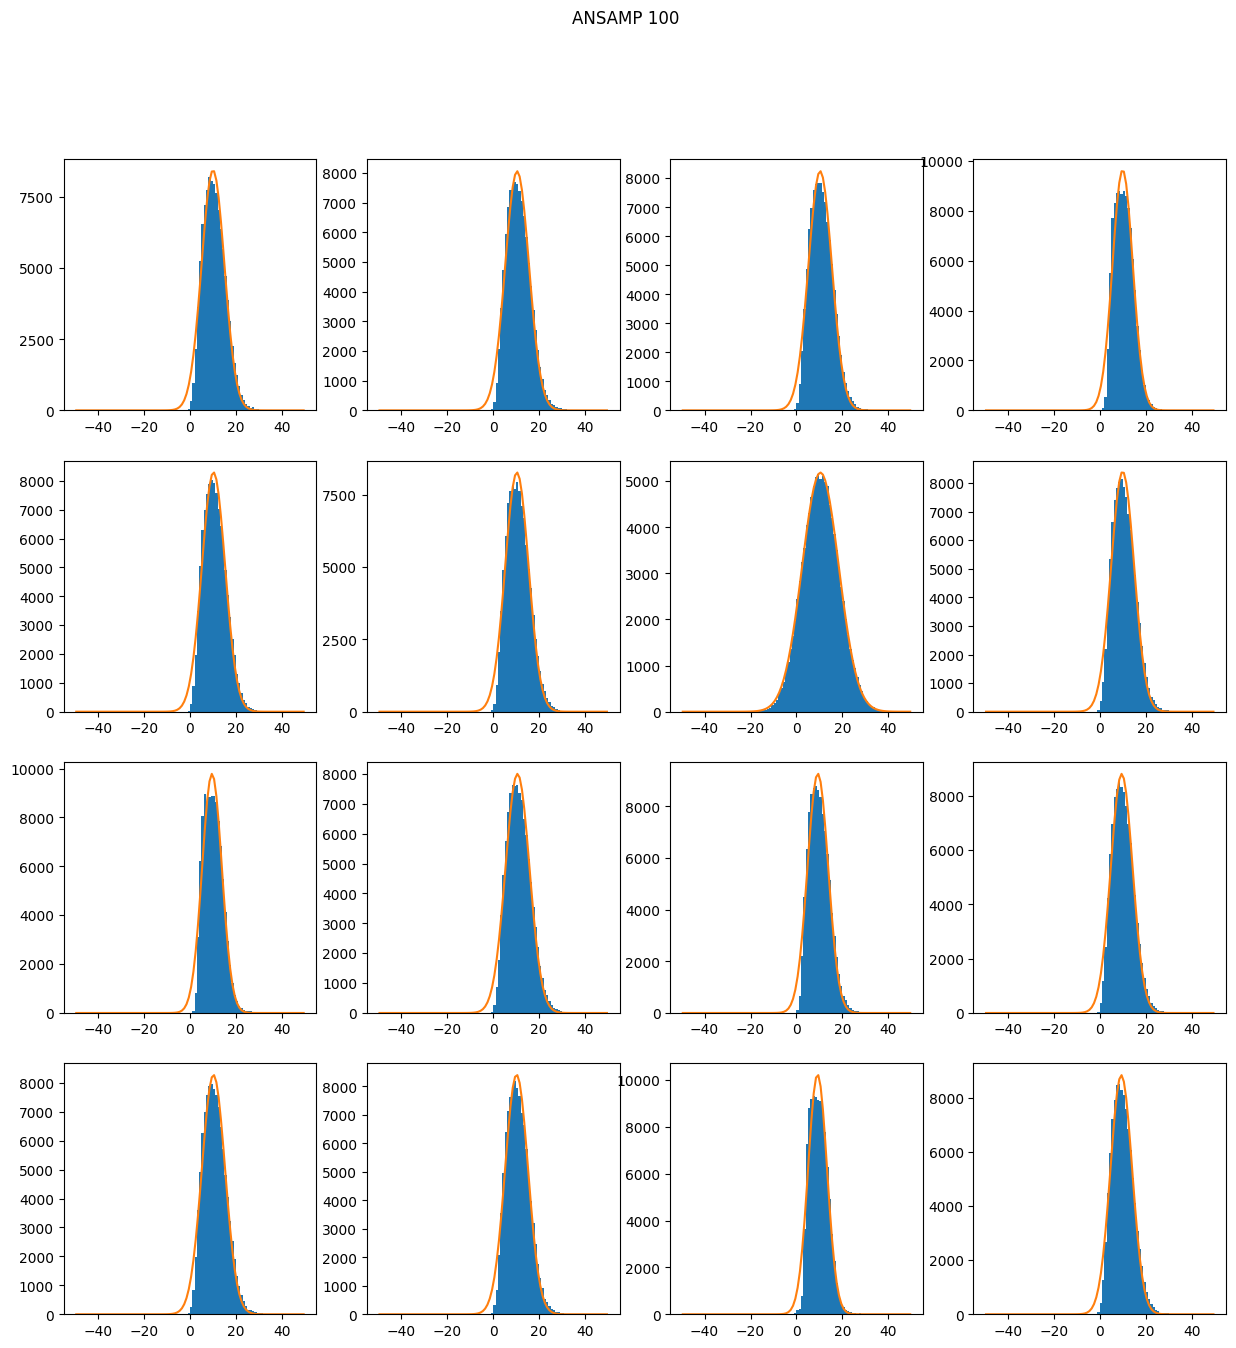

[4.9796371133501625,
 5.182684761252161,
 5.106437931133354,
 4.423725905740825,
 5.068960553482746,
 5.105473005899154,
 8.00019158747426,
 5.011595071534416,
 4.313685210227587,
 5.237849837460458,
 4.535755095524247,
 4.771773744472399,
 5.057000855910564,
 5.001006140496066,
 4.13608620542473,
 4.730738269430869]

In [309]:
# Noise
#noise = Noise(hmb, overscan_mask, MCMNro, nCCDs, ohdusOK, doPlot, pdfname)
noise=anaNoise(hmb, active_mask, MCMNro, nCCDs, ohdusOK, doPlot=True, pdfname='None.pdf')
noise

#
# Gain
#gain = Gain(hmb, active_mask, MCMNro, nCCDs, ohdusOK, doPlot, pdfname)


In [310]:
def Histogram(data):
    histo, bins_edges = np.histogram(data,np.arange(-100, 100, 1))
    class_marks = (bins_edges[:-1]+bins_edges[1:])/2
    #plt.hist(class_marks,bins=bins_edges,weights=histo)
    return histo, bins_edges, class_marks

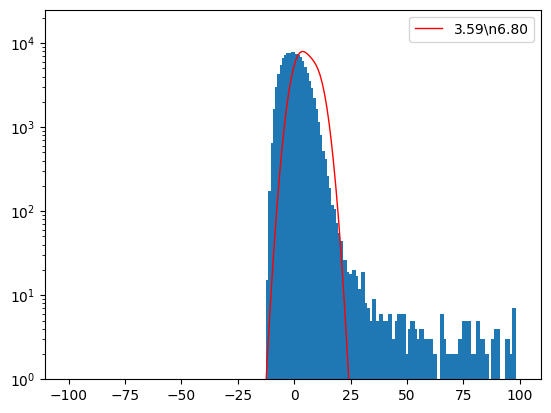

In [319]:
median=np.median(hmb[2].data[active_mask].flatten())
histo, bins, class_marks=Histogram(hmb[2].data[active_mask].flatten()-median)
#x=(bins[1:]+bins[:-1])/2
#gaussian1(x,m1,s1,a1)
popt,pcov=curve_fit(gaussian2,class_marks,histo,p0=[[0,3,1500, 44, 100]]) ##data, mean, stdDev, h1, gain, h2
popt=abs(popt)



plt.bar(class_marks,histo,width=2)

plt.plot(class_marks,gaussian2(class_marks,*popt),linewidth=1,c='r', label=r'{:.2f}\n{:.2f}'.format(popt[1],popt[3]))
plt.yscale('log')
plt.ylim(1,25e3)
plt.legend()
plt.show()


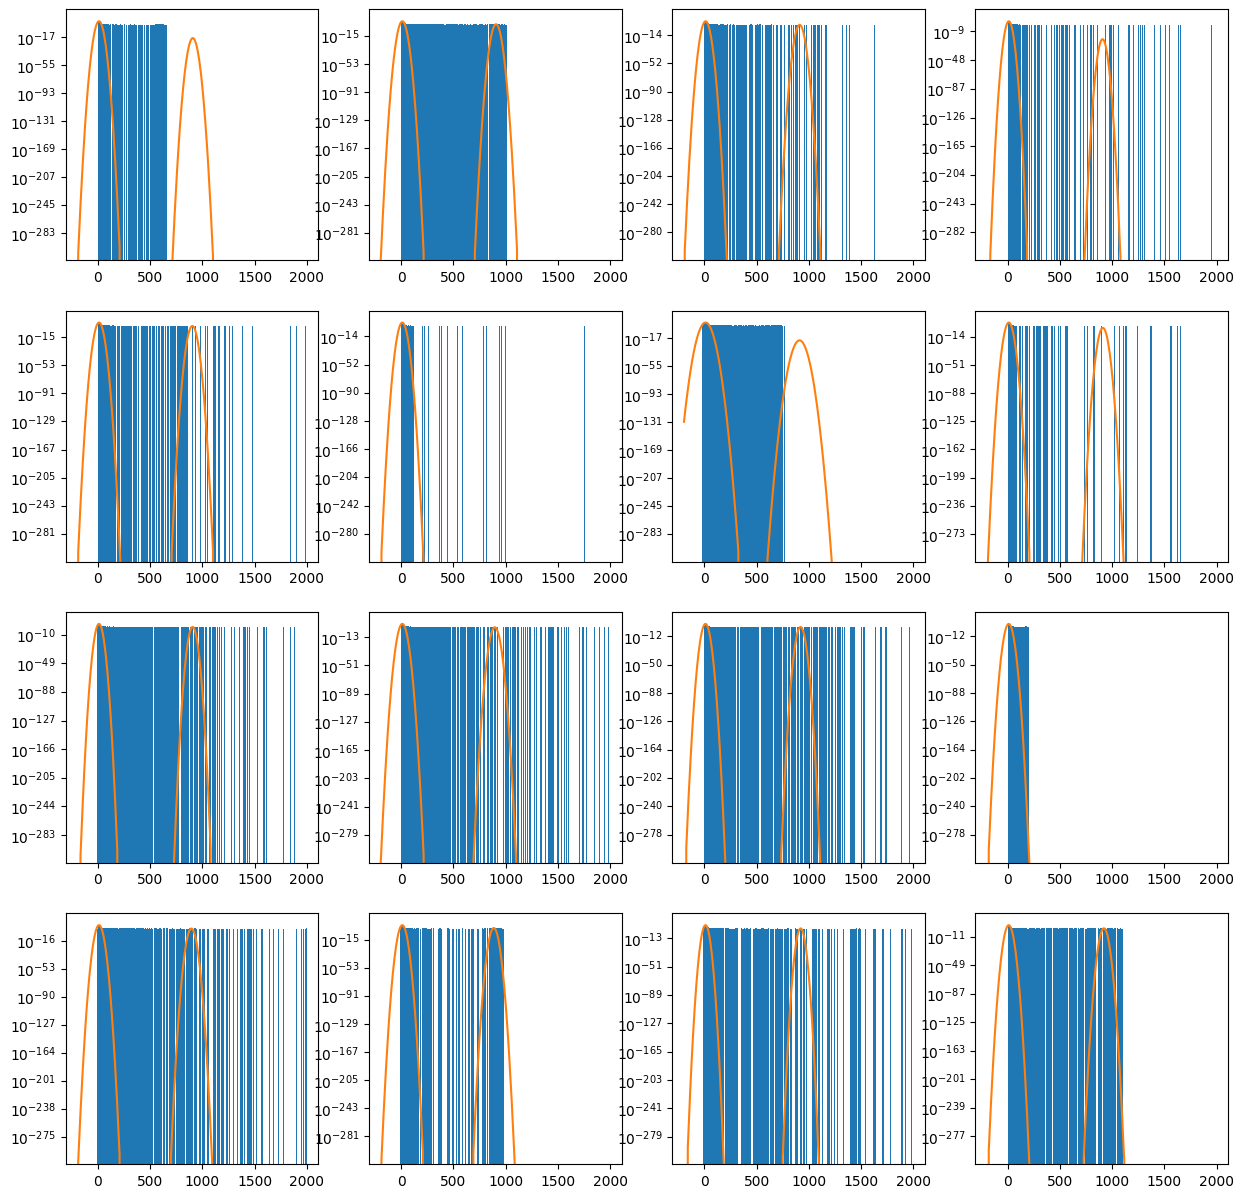

[897.8879619645897,
 897.1067967353555,
 900.785343784482,
 897.3627103878382,
 893.4570081075525,
 897.0101297282487,
 899.7290408904232,
 900.9653548966918,
 896.258799130681,
 885.7587962352862,
 910.470953664535,
 896.9428423050437,
 884.3905213784326,
 875.9526108291188,
 911.5864663391393,
 911.2267968565714]

In [312]:
# Gain
anaGain(hmb, active_mask, MCMNro, nCCDs, ohdusOK, doPlot=True, pdfname='None.pdf')


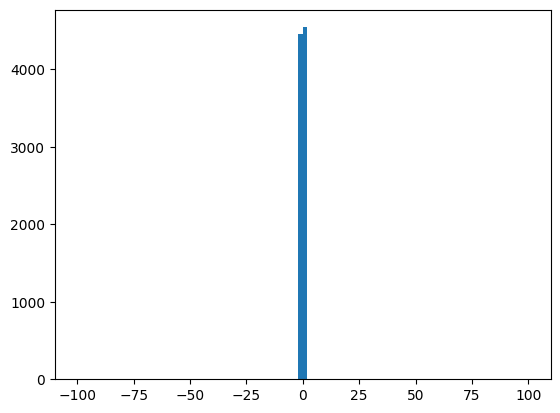

In [313]:
nrow=plt.hist(hmb[1].data[overscan_mask].flatten(),bins=100,range=(-100,100))

#h[i+1].data[overscan_mask].flatten()

In [314]:
#
# SER
ser = ana.Ser(hmb, active_mask, MCMNro, nCCDs, ohdusOK, gain, doPlot, pdfname)
# ----  Print results


NameError: name 'gain' is not defined

In [ ]:
path_files='/home/oem/datosFits/mcm_data/ansamp'
listFiles=os. listdir(path_files) 
numberList = []
dict_list = {}
for i in listFiles:
    dict_list[(i.split('_')[-1]).split('.')[0]]=i

order2process=sorted(dict_list)

for i in order2process:
    fileName=dict_list[i].split('.')[0]
    MCMNro=1
    outname='MCM'+str(MCMNro)+'_Demuxed_'+re.sub(".fz","",fileName)+'.fits';
    step=16
    #Get 16-demuxed Images from the MCM
    #Primary HDU no data, only main header
    Primaryhdu_MCM = fits.PrimaryHDU() # Create primary HDU without data
    hdu_list_MCM = fits.HDUList([Primaryhdu_MCM]) #Create HDU list
    hdu_list_MCM[0].header=h[0].header
    for i in range(0,16):
        MapMCM_ColInit=MappingToMux[MappingToOHDUinfits[i]-1]  #REVISAR ACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaaa!
        datai=np.int32(GetSingleCCDImage(h,hduUse,MapMCM_ColInit,NCOL,step,1))
        #print(datai.dtype)
        image_hdu=fits.ImageHDU(datai);
        image_hdu.header=h[hduUse].header #Repear the header of the used hdu channel into all the 16-channles
        image_hdu.header.set('NSAMP',ANSAMP)
        hdu_list_MCM.append(image_hdu)

    fileHeader=open('fileHeader.txt', 'w')
    fileHeader.write(repr(h[1].header))
    fileHeader.close()

    hdu_list_MCM.writeto(outname,overwrite=True)
    hdu_list_MCM.close()

FileNotFoundError: [Errno 2] No such file or directory: '/home/oem/datosFits/mcm_data/ansamp'

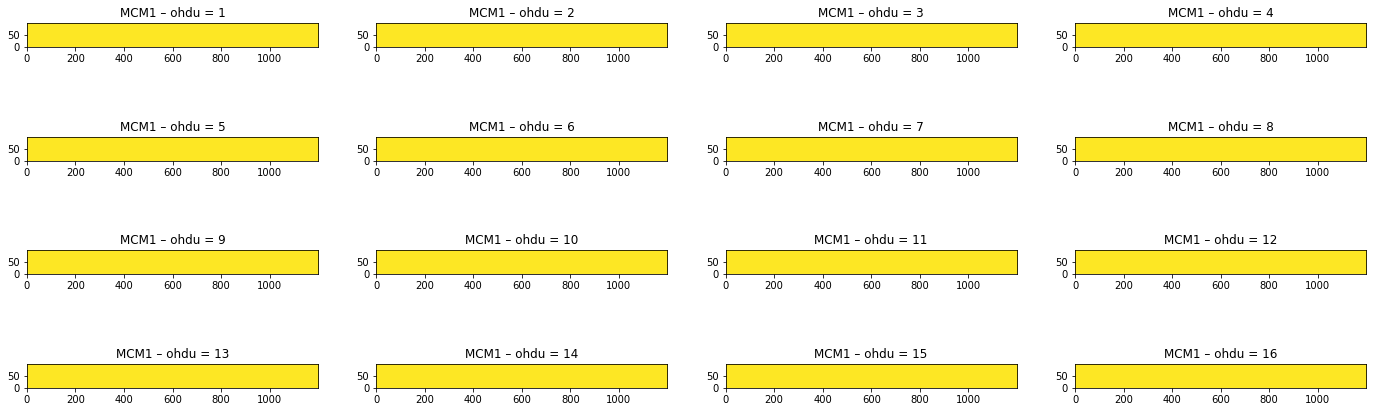

In [ ]:
imName='MCM1_Demuxed_barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP1_18.fits'
image_hdu=fits.open(imName)

plt.figure(figsize=(24,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(image_hdu[i+1].data, vmin=-500, vmax=500)    #Plot de cada imagen en un rango de -500 a 500 ADUS
    plt.title('MCM1 – ohdu = {:d}'.format(i+1))

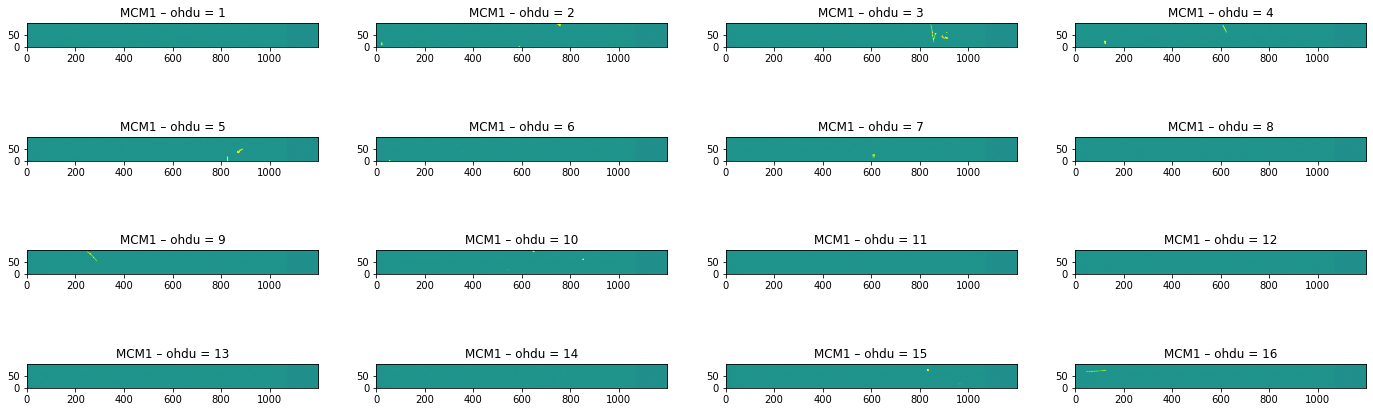

In [ ]:
for i in range(nCCDs):      #el valor de la imagen sera el de la imagen cruda menos la mediana
    image_hdu[i+1].data = hm[i+1].data.astype('float64') - np.median(hm[i+1].data[overscan_mask], axis=1, keepdims=True)

plt.figure(figsize=(24,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(image_hdu[i+1].data[:,:], vmin=-500, vmax=500)    #Plot de cada imagen en un rango de -500 a 500 ADUS
    plt.title('MCM1 – ohdu = {:d}'.format(i+1))



/tmp/ipykernel_3535/1508123804.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,i+1)


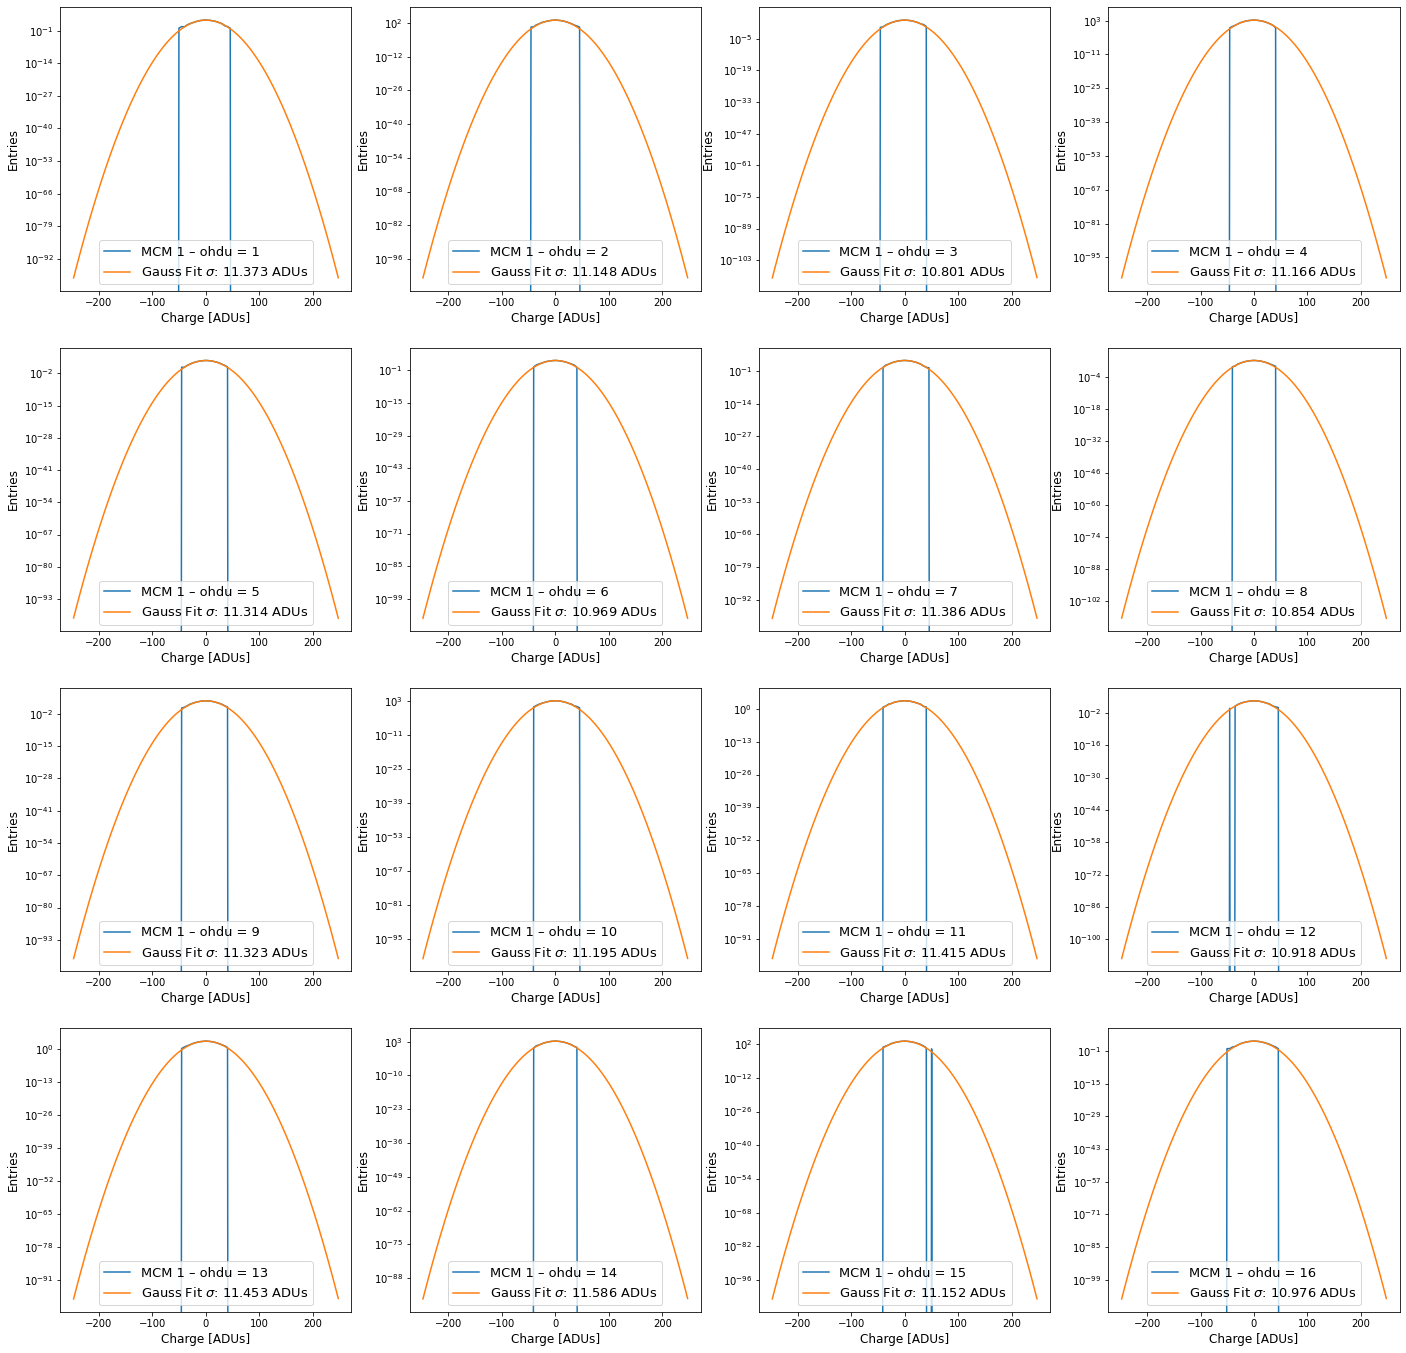

In [ ]:
noise = Noise(image_hdu, overscan_mask, MCMNro, nCCDs, ohdusOK, doPlot=True, pdfname='None.pdf')

In [ ]:
ohdusOK

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
path_files='/home/mauricio/datosFits/mcm_data/ansamp'
listFiles=os. listdir(path_files) 
numberList = []
dict_list = {}
noise_list = []
for i in listFiles:
    dict_list[(i.split('_')[-1]).split('.')[0]]=i

order2process=sorted(dict_list)

for i in order2process:
    fileName=dict_list[i].split('.')[0]
    MCMNro=1
    outname='MCM'+str(MCMNro)+'_Demuxed_'+re.sub(".fz","",fileName)+'.fits';
    step=16
    #Get 16-demuxed Images from the MCM
    #Primary HDU no data, only main header
    Primaryhdu_MCM = fits.PrimaryHDU() # Create primary HDU without data
    hdu_list_MCM = fits.HDUList([Primaryhdu_MCM]) #Create HDU list
    hdu_list_MCM[0].header=h[0].header
    for i in range(0,16):
        MapMCM_ColInit=MappingToMux[MappingToOHDUinfits[i]-1]  #REVISAR ACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaaa!
        datai=np.int32(GetSingleCCDImage(h,hduUse,MapMCM_ColInit,NCOL,step,1))
        #print(datai.dtype)
        image_hdu=fits.ImageHDU(datai);
        image_hdu.header=h[hduUse].header #Repear the header of the used hdu channel into all the 16-channles
        image_hdu.header.set('NSAMP',ANSAMP)
        hdu_list_MCM.append(image_hdu)

    fileHeader=open('fileHeader.txt', 'w')
    fileHeader.write(repr(h[1].header))
    fileHeader.close()

    hdu_list_MCM.writeto(outname,overwrite=True)
    hdu_list_MCM.close()
    
    noise_list.append(Noise(hdu_list_MCM, overscan_mask, MCMNro, nCCDs, ohdusOK, doPlot=False, pdfname='None.pdf'))
    

/tmp/ipykernel_3535/1508123804.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,i+1)
/home/mauricio/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_3535/1508123804.py:25: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


In [ ]:
file_FITS=file_FITS=fits.open('/home/oem/Software/cursoInstrumentacion_2022/ClasesPy/60 - MCM Test/MCM1_Demuxed_barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP400_27.fits')

In [ ]:
Noise(file_FITS, overscan_mask, MCMNro, nCCDs, ohdusOK, doPlot=False, pdfname='None.pdf')

/tmp/ipykernel_31635/1254288085.py:25: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


[100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


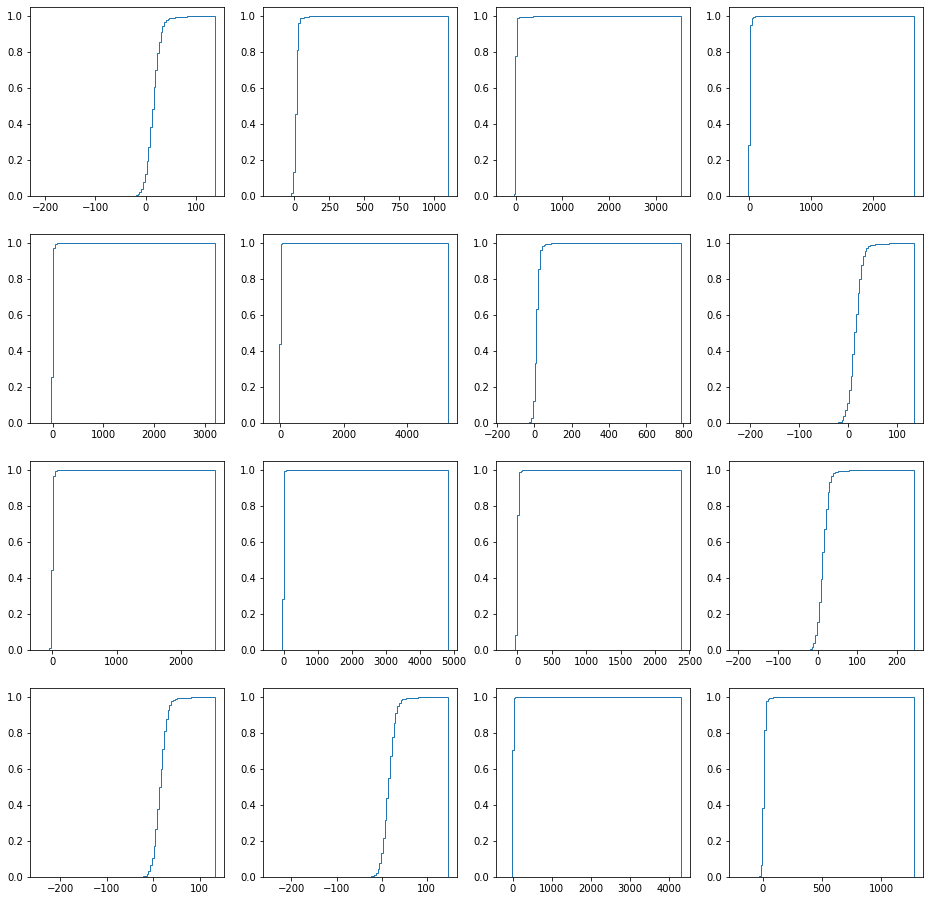

In [ ]:
ohdusOK = np.zeros((16,), dtype=int)
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    y, x, _ = plt.hist(hmb[i+1].data[active_mask].flatten(),100,density=True, histtype='step', cumulative=True)
    #print(i,x.max())
    if x.max()>100: ohdusOK[i]=1
print(ohdusOK)

In [ ]:
def NoiseBkp(h, overscan_mask, iMCM, nCCDs, dataOK, doPlot, pdfname):
    noise = []
    plt.figure(figsize=(24,24))
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.title("MCM {:d}".format(iMCM), fontsize=18)
    for i in range(nCCDs):
        if dataOK[i]:
            plt.subplot(4,4,i+1)
            y,xb=np.histogram(h[i+1].data[overscan_mask].flatten(), bins=np.linspace(-250,250,200))
            x=(xb[1:]+xb[:-1])/2
            plt.plot(x,y,label='MCM {:d} – ohdu = {:d}'.format(iMCM,i+1))
            # gaussian fit
            try:
                popt,pcov=curve_fit(gaussian1,x,y,p0=[-10,100,10000])
                plt.plot(x,gaussian1(x,*popt),label="Gauss Fit $\sigma$: {:.3f} ADUs".format(popt[1]))
                noise.append(popt[1])
            except RuntimeError:
                print("Error - gain fit failed" + pdfname)
                noise.append(-1)
            plt.legend(fontsize=13)
            plt.xlabel("Charge [ADUs]",fontsize=12)
            plt.yscale("log")
            plt.ylabel("Entries",fontsize=12)
        else: noise.append(-1)
    # to save the plot
    #pdf_filename = f'noise_'+pdfname+'_{iMCM+1}.pdf'i
    if doPlot:
        # pdf_filename = f'noise_{pdfname}.pdf'
        # plt.savefig(pdf_filename, format='pdf')
        plt.show()
    plt.close()
    return noise

/tmp/ipykernel_4312/2956685803.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,i+1)


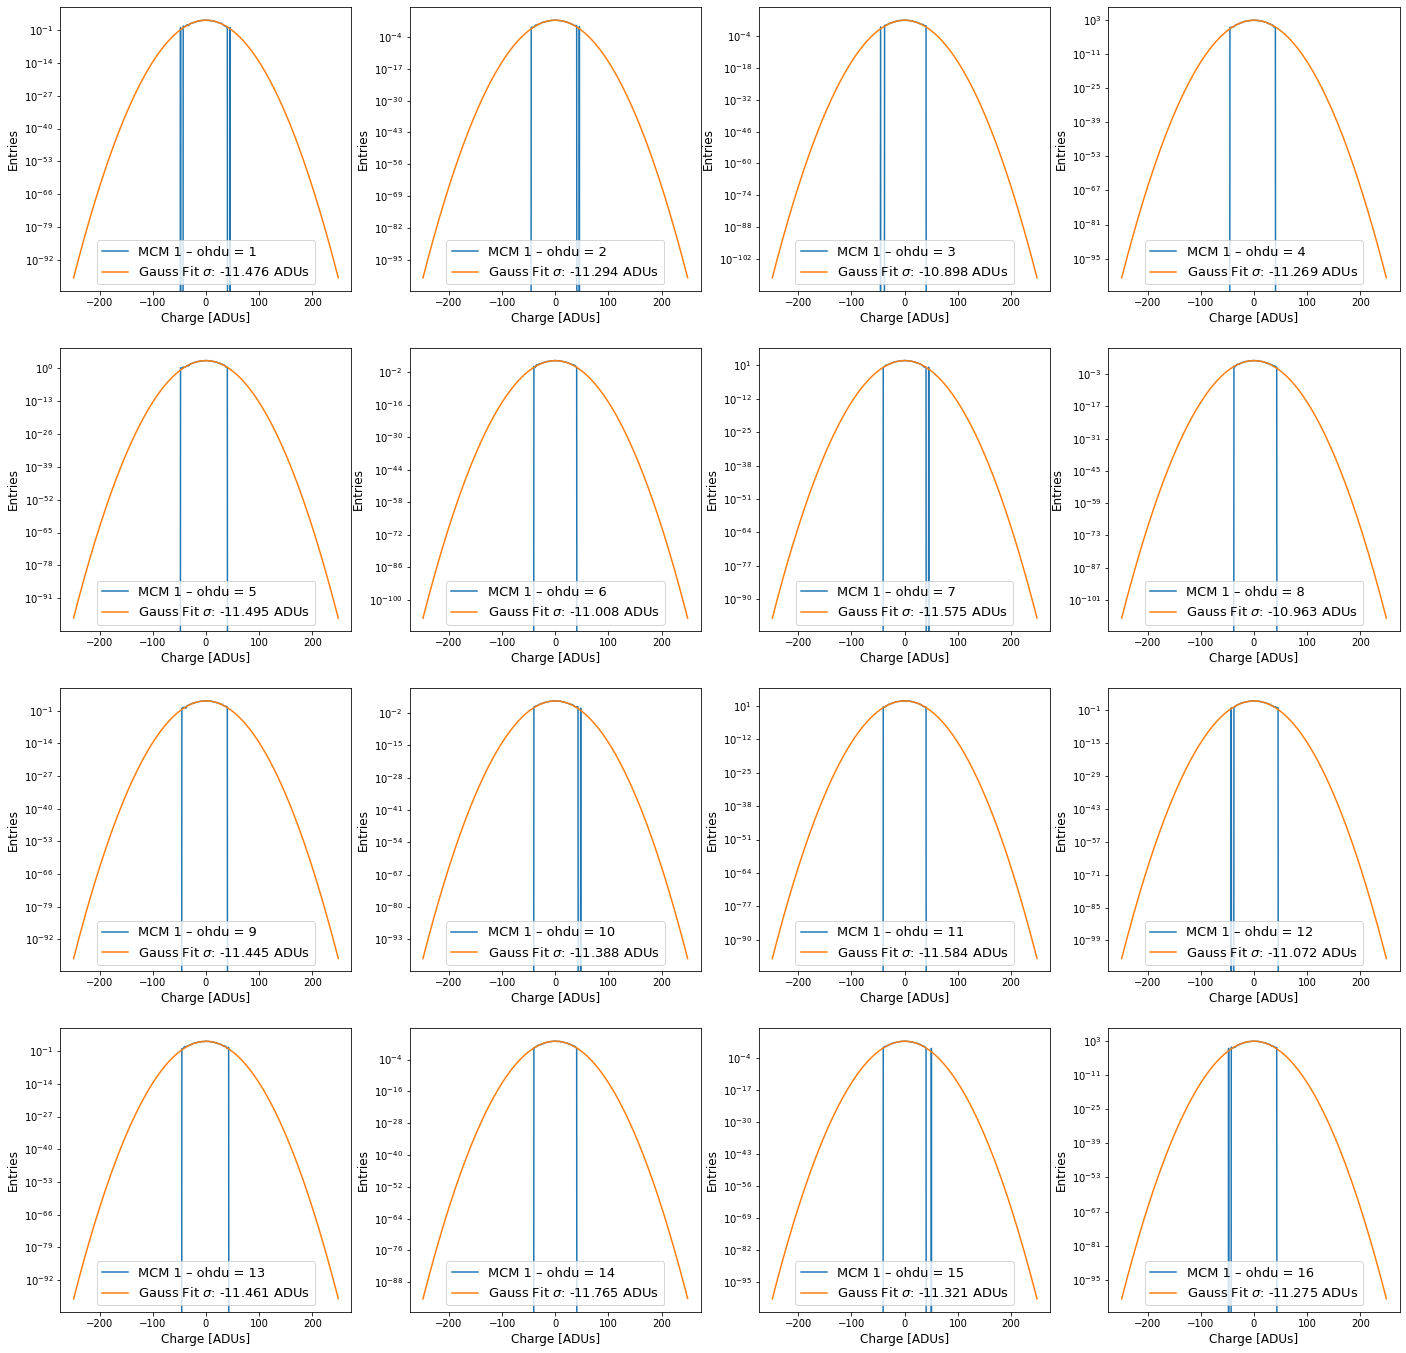

In [ ]:
noise = NoiseBkp(hmb, overscan_mask, MCMNro, nCCDs, ohdusOK, doPlot, pdfname)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   4.,   0.,   2.,   4.,  13.,
          3.,  13.,  27.,  42.,  49.,  75.,  84., 132., 203., 240., 297.,
        392., 492., 512., 521., 623., 604., 696., 597., 568., 501., 438.,
        404., 374., 283., 213., 194., 126.,  83.,  63.,  54.,  41.,  16.,
          7.,   4.,   0.,   4.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([-100.,  -98.,  -96.,  -94.,  -92.,  -90.,  -88.,  -86.,  -84.,
         -82.,  -80.,  -78.,  -76.,  -74.,  -72.,  -70.,  -68.,  -66.,
         -64.,  -62.,  -60.,  -58.,  -56.,  -54.,  -52.,  -50.,  -48.,
         -46.,  -44.,  -42.,  -40.,  -38.,  -36.,  -34.,  -32.,  -30.,
         -28.,  -26.,  -24.,  -22.